# HW1: Regression and Model Selection
---
The prototypical MNIST dataset is used to demonstrate the introductory regression and model selection techniques. Lasso, ridge and Moore-Penrose pseudo-inverse are chosen as regression techniques.

The main focus of this report is to explore promoting sparsity in regression techniques. The degree to which reduced pixel models can accurately model the whole system is investigated.

## Ugly initialisations and library stuff

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import model_selection

In [2]:
# Modified from a previous project where I copied from a AutoEncoder example
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
# Ignore this, it's ugly as sin
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

In [4]:
# My Colour scheme
#  every self-respecting/loathing millenial has their own, right?
orange = '#FFA500'
millenialPink = '#FFAADD'
mediumAquamarine = '#66CDAA'

## Create Matrices as Required

In [5]:
# Convert from integer to unit vector in 10x10 Identity matrix
#  Look at HW brief for clarification
def LabelConvert(label):
    if label == 0: label = 10 
    I = np.identity(10,dtype=int)
    return I[label-1,:]

# Funky signature to allow scalar->vector
VectoriseLabel = np.vectorize(LabelConvert,signature='()->(n)')

In [6]:
# Global Parameters
ROWS = 28 # We're using MNISt
COLS = 28 # Hard coded because I'm lazy and hate myself
# https://twitter.com/EmilyEAckerman/status/1252332547117383680?s=20

# Takes MNIST image, spews out big ol' 1D vector
def Image2Vector(array):
    return array.reshape(ROWS*COLS)

# Handy dandy vectorisation
Vectorise2Images = np.vectorize(Image2Vector,signature='(n,n)->(m)')

# Opposite of prior
def Vector2Image(array):
    return array.reshape(ROWS,COLS)  

In [7]:
# Into the lovely mathsy notation
B = VectoriseLabel(train_labels)
A = Vectorise2Images(train_images)

In [8]:
print(B.shape) # PHWOAR, our first print
print(A.shape)

(60000, 10)
(60000, 784)


## Question 1: Using Various AX=B solvers, determinate a mapping from the image space to the label space.
---
Use different solvers (lasso, ridge and pinv) we find different X matrices to map from image vectors to label vectors.

### Lasso

In [9]:
# This funky business is what I'd expect LassoCV to do
# n_jobs=-1 uses all the processes it can find
# [0.1] because apparently the normal thing is to try multuple alphas???
lassoModel = linear_model.MultiTaskLassoCV(verbose=2,alphas=[0.1],copy_X=False,n_jobs=-1,normalize=False,max_iter=32)
lassoModel.fit(A,B) # This can take a couple minutes on my teeny macbook pro, like a couple^2
print(lassoModel.coef_.shape)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Path: 000 out of 001
Path: 000 out of 001
Path: 000 out of 001


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


(10, 784)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1822: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


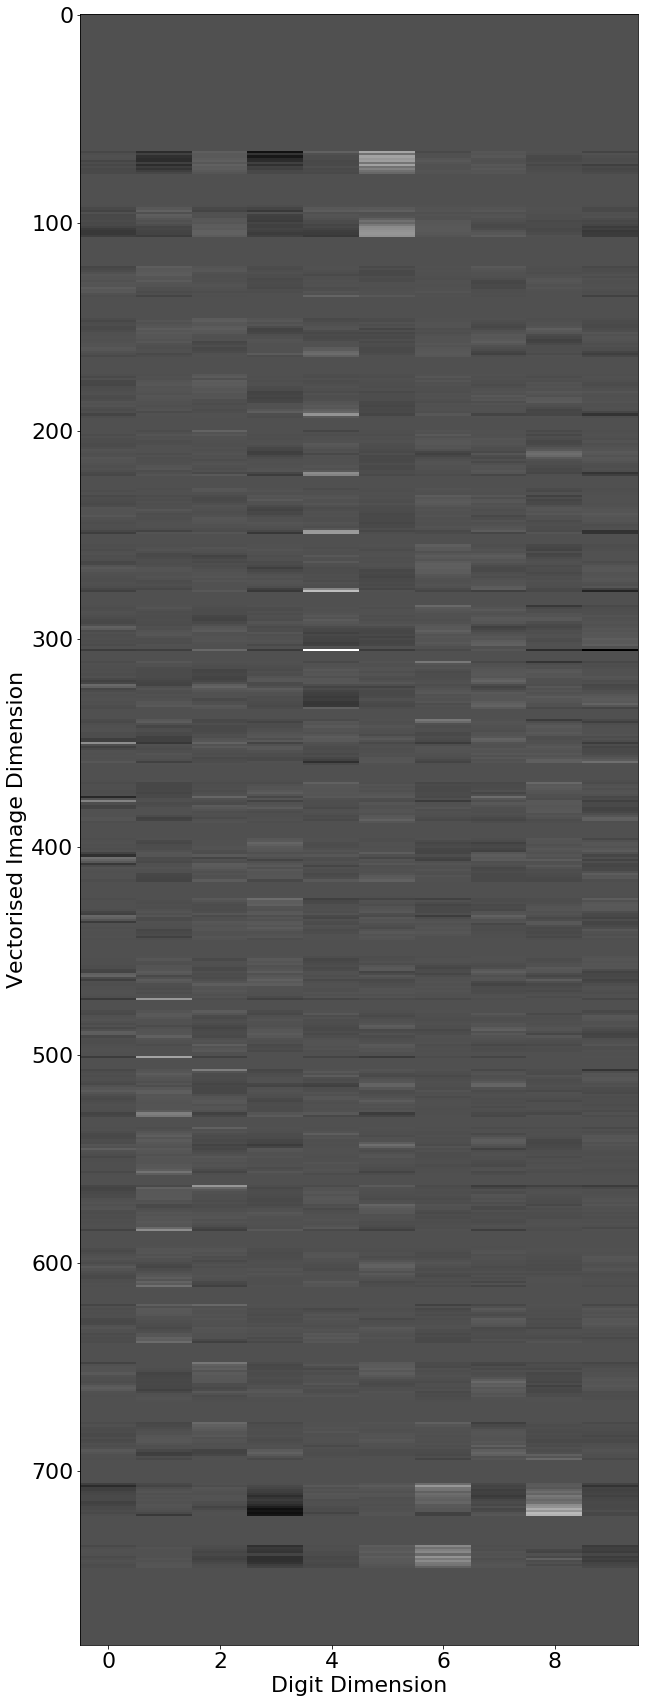

In [10]:
# This doesn't show anything too interesting, but ya' know
plt.figure(figsize = (10,30)) # trying to get some kinda scale to work
plt.imshow(lassoModel.coef_.T,cmap='gray',aspect='auto')
plt.xlabel('Digit Dimension')
plt.ylabel('Vectorised Image Dimension')
plt.savefig('./Images/lassoModel_tenth.png')
plt.show()

### Ridge

In [11]:
ridgeModel = linear_model.RidgeCV([0.1],normalize=True) # Ain't this so much easier?
ridgeModel.fit(A,B) # This can take a couple minutes on my teeny macbook pro
print(ridgeModel.coef_.shape)

(10, 784)


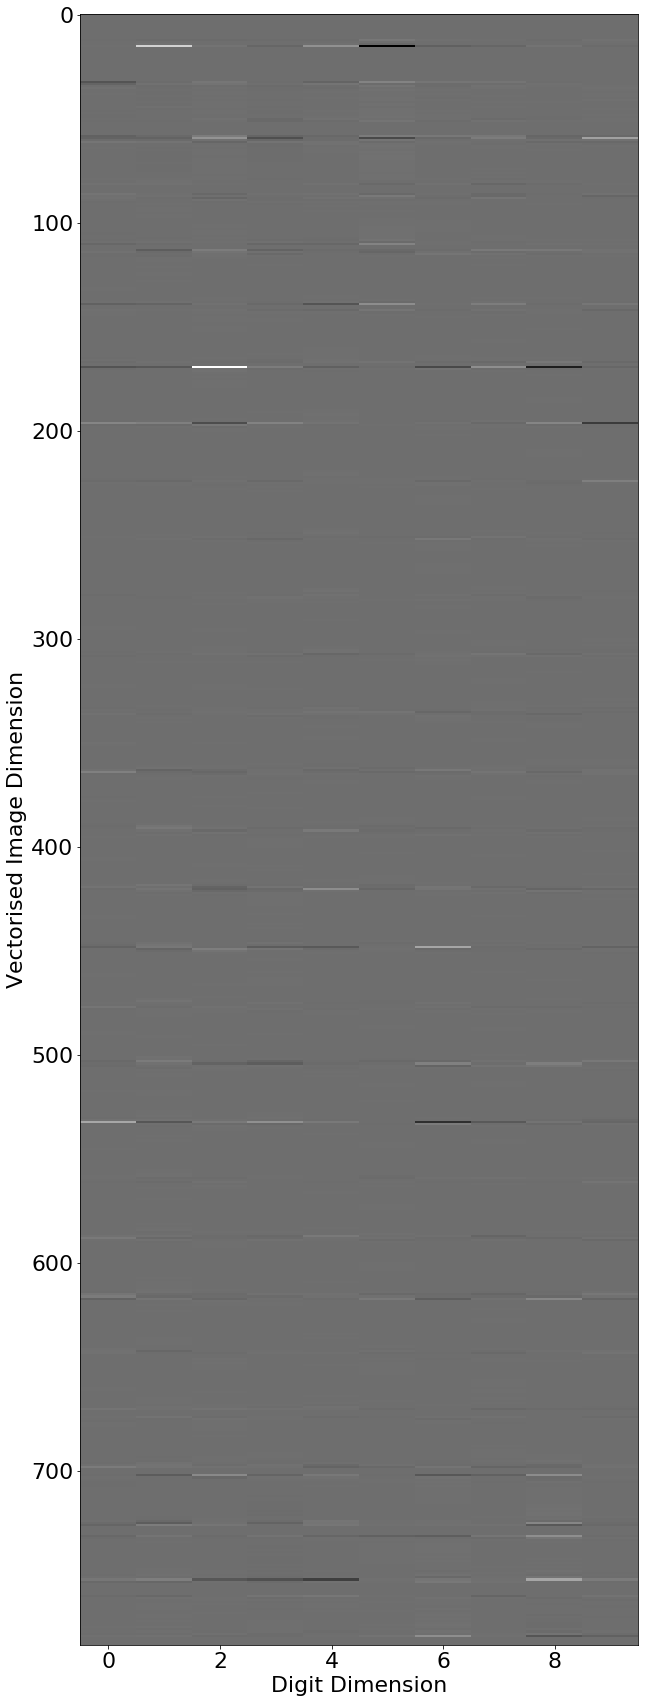

In [12]:
# This doesn't show anything too interesting, but ya' know
plt.figure(figsize = (10,30)) # trying to get some kinda scale to work
plt.imshow(ridgeModel.coef_.T,cmap='gray',aspect='auto')
plt.xlabel('Digit Dimension')
plt.ylabel('Vectorised Image Dimension')
plt.savefig('./Images/ridgeModel_tenth.png')
plt.show()

### Pseudo-Inverse

In [13]:
# Implement k-fold cross validation on PInv
def PInvKFold(A,B,k=5):
    kf = model_selection.KFold(n_splits=k)
    p = [np.linalg.pinv(A[i])@B[i] for i,_ in kf.split(A)]
    return np.mean(p,axis=0)

In [14]:
pinvMatrix = PInvKFold(A,B) # Here goes nothing

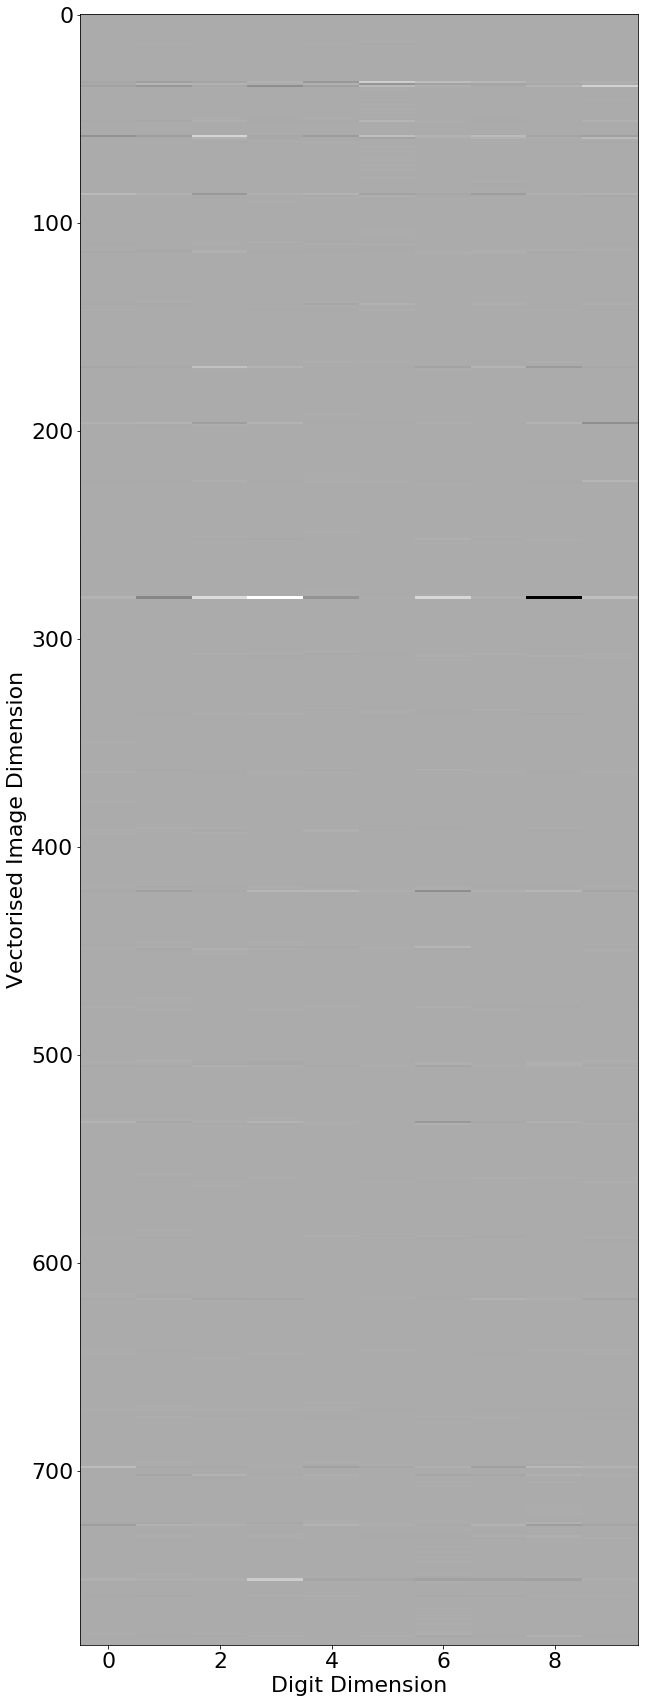

In [15]:
# This doesn't show anything too interesting, but ya' know
plt.figure(figsize = (10,30)) # trying to get some kinda scale to work
plt.imshow(pinvMatrix,cmap='gray',aspect='auto')
plt.xlabel('Digit Dimension')
plt.ylabel('Vectorised Image Dimension')
plt.savefig('./Images/pinvModel_tenth.png')
plt.show()

## Prediction Functions

In [16]:
# Trivially take a vector and spew out the index of the highest scalar
def PredictLabel(x,meanAdjustment=0):
    x -= meanAdjustment
    # Might want to remove the avg. value
    #  because training set not necessarilly uniform
    return np.argmax(x)+1   

In [17]:
# Calculate averages
#  Could be single lines, but for your visual pleasure...
lassoAvg = lassoModel.predict(A)
lassoAvg = np.mean(lassoAvg,axis=0)
ridgeAvg = ridgeModel.predict(A)
ridgeAvg = np.mean(ridgeAvg,axis=0)
pinvAvg = A @ pinvMatrix
pinvAvg = np.mean(pinvAvg,axis=0)

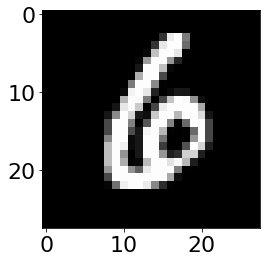

Actual digit    : 6
Lasso Prediction: 6
Ridge Prediction: 6
PInv  Prediction: 6


In [18]:
# Temporary testing, that's become permanent
#  Good sanity check
exampleIndex = 93
ti = A[exampleIndex] # test image
x = lassoModel.predict([ti])
plt.imshow(Vector2Image(ti),cmap='gray')
plt.show()
print('Actual digit    : '+str(PredictLabel(B[exampleIndex])))
print('Lasso Prediction: '+str(PredictLabel(lassoModel.predict([ti]),meanAdjustment=lassoAvg)))
print('Ridge Prediction: '+str(PredictLabel(ridgeModel.predict([ti]),meanAdjustment=ridgeAvg)))
print('PInv  Prediction: '+str(PredictLabel([ti]@pinvMatrix,meanAdjustment=pinvAvg)))

In [19]:
# Simple thing to find accuracy using input A&B
#  assumes that PredictLabel on B finds ground truth
def AccuracyMat(testImages,testLabels,coeff,avg):
    total = 0
    for i in range(testImages.shape[0]):
        a = PredictLabel(testLabels[i]) # actual - damn hope anyways
        x = [testImages[i]]@coeff
        p = PredictLabel(x,meanAdjustment=avg)
        if a == p: total += 1
        #else: print([a,p,i])
    return total/(testImages.shape[0])

# I couldn't think of a better way to write one function
#  WAAYYY to much effort to make a class for PInv
def AccuracyModel(testImages,testLabels,model,avg):
    total = 0
    for i in range(testImages.shape[0]):
        a = PredictLabel(testLabels[i]) # actual - damn hope anyways
        x = model.predict([testImages[i]])
        p = PredictLabel(x,meanAdjustment=avg)
        if a == p: total += 1
    return total/(testImages.shape[0])

In [20]:
# Put test set in same notation as training
Btest = VectoriseLabel(test_labels)
Atest = Vectorise2Images(test_images)

# Print out model accuracy, because why not?
print('Lasso Accuracy: '+str(AccuracyModel(Atest,Btest,lassoModel,lassoAvg)))
print('Ridge Accuracy:  '+str(AccuracyModel(Atest,Btest,ridgeModel,ridgeAvg)))
print('PInv Accuracy:  '+str(AccuracyMat(Atest,Btest,pinvMatrix,pinvAvg)))

Lasso Accuracy: 0.864
Ridge Accuracy:  0.8627
PInv Accuracy:  0.854


In [21]:
# Ignore this, it's ugly as sin
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

## Question 2: By promoting sparsity, determine and rank which pixels in the MNIST set are most informative for correctly labeling the digits.

To find the most important pixels, I find the corresponding coefficient columns with the highest norm. This is definitely useful for the pseduo inverse - though prediction is something more than a matrix multiply for the other two methods, so is unclear if appropriate. We shall find out, seemingly.

In [22]:
# This is ugly, don't look too close here
# There's graphs a few boxes down - look at those instead
def FindImportantPixelsIndex(coeff,n,weights,norm=2):
    # Find the norm for the colms of coefficient which corresponds to pixels
    pixelNorm = np.linalg.norm(coeff,ord=norm,axis=1)
    # Weight them, by how frequently they are used
    pixelNorm = np.multiply(pixelNorm,weights)
    importantPixelsIndex = np.argsort(pixelNorm)[-n:]
    return importantPixelsIndex
    

def FindImportantPixels(coeff,n,weights,norm=2):
    importantPixelsIndex = FindImportantPixelsIndex(coeff,n,weights,norm)
    pixelNorm = np.linalg.norm(coeff,ord=norm,axis=1)
    # important pixel matrix
    ipMat = np.zeros(coeff.shape[0])
    ipMat[importantPixelsIndex] = pixelNorm[importantPixelsIndex]
    return ipMat

In [23]:
pixelQuantity = 256 # Pick something

In [24]:
w = np.mean(A,axis=0) # The avg. weights for the dataset

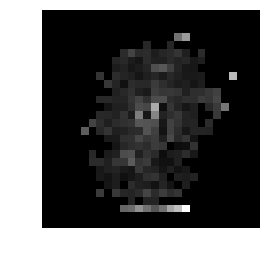

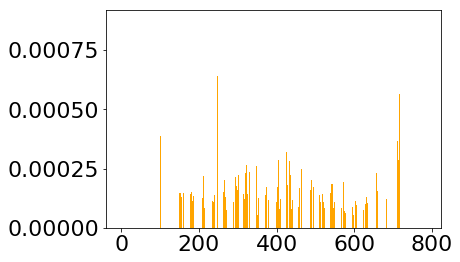

In [25]:
# Lasso's most important pixels
iL = FindImportantPixels(lassoModel.coef_.T,pixelQuantity,w)
plt.imshow(Vector2Image(iL),cmap='gray')
plt.axis('off')
plt.savefig('./Images/imLasso.png')
plt.show()
plt.bar(range(len(iL)),iL,color=orange)
plt.show()

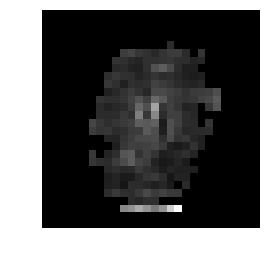

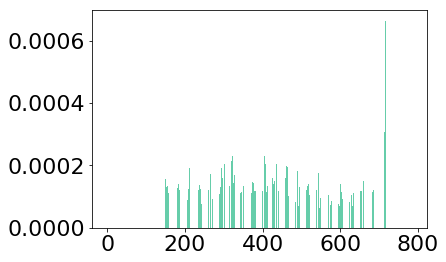

In [26]:
# Ridge, same thing as above and below
iR = FindImportantPixels(ridgeModel.coef_.T,pixelQuantity,w)
plt.imshow(Vector2Image(iR),cmap='gray')
plt.axis('off')
plt.savefig('./Images/imRidge.png')
plt.show()
plt.bar(range(len(iR)),iR,color=mediumAquamarine)
plt.show()

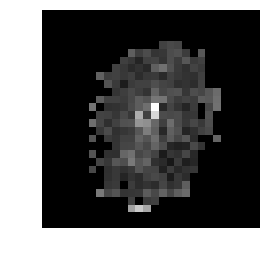

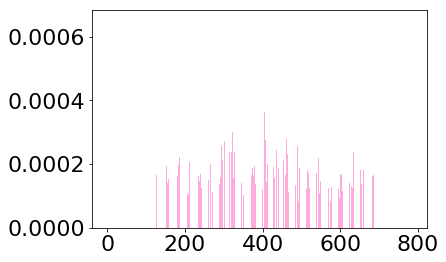

In [27]:
# PInv most important pixels
iP = FindImportantPixels(pinvMatrix,pixelQuantity,w,norm=2)
plt.imshow(Vector2Image(iP),cmap='gray')
plt.axis('off')
plt.savefig('./Images/imPinv.png')
plt.show()
plt.bar(range(len(iP)),iP,color=millenialPink)
plt.show()

In [28]:
# Now to actually answer the question
# Choose 4 different alpha values, compare their important pixels
alphaValues = [0.1,0.2,0.5,1,10,20]
# Humour me, I like a good list generator
lassoModels = [linear_model.MultiTaskLassoCV(cv=3,alphas=[a],copy_X=False,n_jobs=-1,normalize=False,max_iter=32).fit(A,B) for a in alphaValues]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1822: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1822: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.7/site-

Accuracy for 0.1 is 0.864
Accuracy for 0.2 is 0.8629
Accuracy for 0.5 is 0.8592
Accuracy for 1 is 0.8527
Accuracy for 10 is 0.7152
Accuracy for 20 is 0.3742


/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


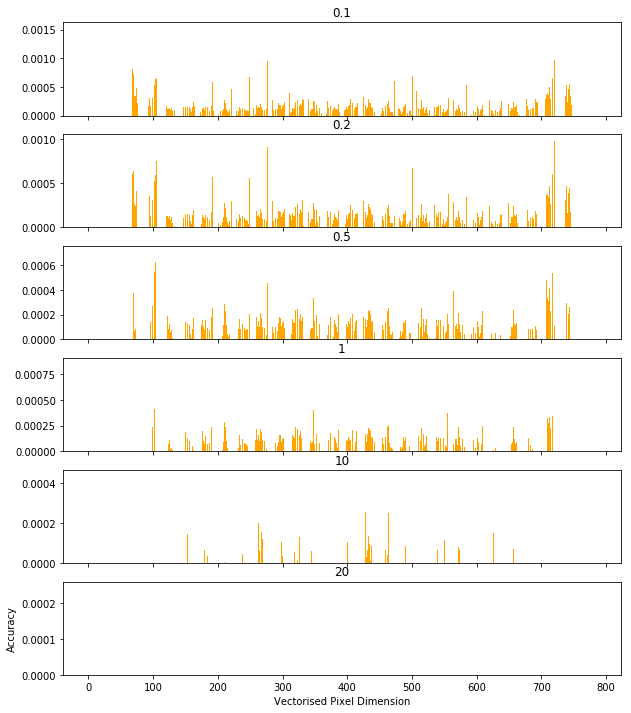

In [29]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

pixelQuantity = 28*28 # Cheeky using no. important pixels as all of 'em

f, axs = plt.subplots(len(alphaValues),1,figsize=(10,12),sharex=True)
for i in range(len(alphaValues)):
    im = FindImportantPixels(lassoModels[i].coef_.T,pixelQuantity,w)
    axs[i].bar(range(len(im)),im,color=orange)
    axs[i].set_title(str(alphaValues[i]))
    print('Accuracy for ' +str(alphaValues[i]) + ' is ' + str(AccuracyModel(Atest,Btest,lassoModels[i],lassoAvg)))
    
plt.ylabel('Accuracy')
axs[-1].set_xlabel('Vectorised Pixel Dimension')
plt.savefig('./Images/sparsityLassoBar.png')
plt.show()

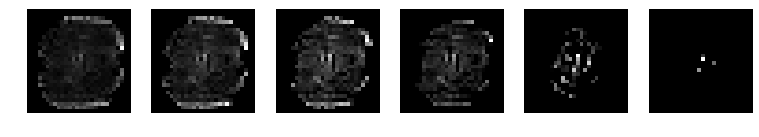

In [30]:
# Plot all of the norms for each alpha value
# Same as all the most important pixels
f, axs = plt.subplots(1,len(alphaValues),figsize=(13,4))
for i in range(len(alphaValues)):
    im = FindImportantPixels(lassoModels[i].coef_.T,pixelQuantity,w)
    axs[i].imshow(Vector2Image(im),cmap='gray')
    axs[i].axis('off')
plt.savefig('./Images/sparsityLassoIm.png')

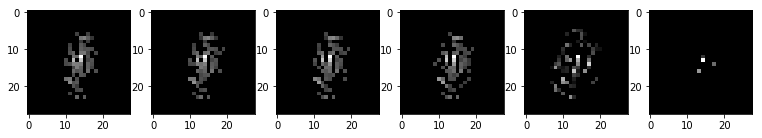

In [31]:
# Plot the top 64 pixels for each alpha value.
f, axs = plt.subplots(1,len(alphaValues),figsize=(13,4))
for i in range(len(alphaValues)):
    im = FindImportantPixels(lassoModels[i].coef_.T,64,w)
    axs[i].imshow(Vector2Image(im),cmap='gray')
plt.savefig('./Images/sparsityLassoIm.png')

## Question 3: Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

In [32]:
# Takes a matrix, and important pixel indexs
# Sets all columns not indexed to zero
# ** returns copy
def ApplyImportantPixels(A,IP):
    P = np.zeros(A.shape)
    P[:,IP] = A[:,IP]
    return P

PInv Accuracy:  0.854
PInv Accuracy with important pixels:  0.4116


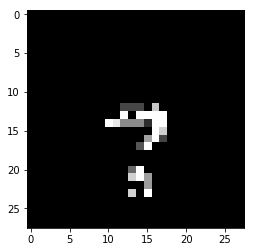

In [33]:
# Find importantPixelIndex
# Apparently we choose 64, no reason though - you can go wild here
iPIndex = FindImportantPixelsIndex(pinvMatrix,64,norm=2,weights=w)
# Create an A using the importantPixelIndex
Ai = ApplyImportantPixels(Atest,iPIndex)
plt.imshow(Vector2Image(Ai[6]),cmap='gray')
print('PInv Accuracy:  '+str(AccuracyMat(Atest,Btest,pinvMatrix,pinvAvg)))
print('PInv Accuracy with important pixels:  '+str(AccuracyMat(Ai,Btest,pinvMatrix,pinvAvg)))

In [34]:
# Using a space of integers in X, find the accuracy using this many important pixels
# Can use models or matrices, matrices require mat=True **
def CalculateAccuracyWithImportance(X,A,B,model,weights,mat=False,norm=2,avg=0):
    Y = []
    for i in X:
        #print('calculating accuracies for ' + str(i) + ' most important pixels...')
        if mat:
            ii = FindImportantPixelsIndex(model,i,weights,norm=norm)
        else:
            ii = FindImportantPixelsIndex(model.coef_.T,i,weights,norm=norm)
        Ai = ApplyImportantPixels(A,ii)
        if mat:
            y = AccuracyMat(Ai,B,model,avg)
        else:
            y = AccuracyModel(Ai,B,model,avg)
        #print('...accuracy found to be ' + str(y))
        Y.append(y)
    return Y

In [35]:
# Arbitary range, but something reasonable for my laptop
X = range(1,400,25)
lassoAcImp = CalculateAccuracyWithImportance(X,Atest,Btest,lassoModel,w)
ridgeAcImp = CalculateAccuracyWithImportance(X,Atest,Btest,ridgeModel,w)
pinvAcImp = CalculateAccuracyWithImportance(X,Atest,Btest,pinvMatrix,w,mat=True)

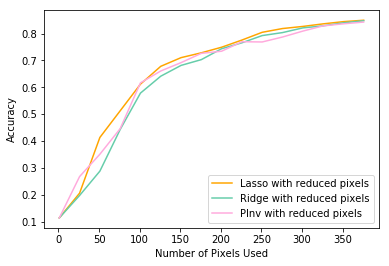

In [36]:
# Plot em all on a graph pal!
fig, ax = plt.subplots()

ax.plot(X,lassoAcImp,label='Lasso with reduced pixels',c=orange,linestyle='-')
ax.plot(X,ridgeAcImp,label='Ridge with reduced pixels',c=mediumAquamarine,linestyle='-')
ax.plot(X,pinvAcImp,label='PInv with reduced pixels',c=millenialPink,linestyle='-')

ax.set_xlabel('Number of Pixels Used')
ax.set_ylabel('Accuracy')

ax.legend()
plt.savefig('./Images/compareReduced.png')
plt.show()

In [37]:
# Create some dodgy thing to actually learn new models with reduced important dimensions
def LearnReducedModelPInv(i):
    ip = FindImportantPixelsIndex(pinvMatrix,i,w,norm=2)
    Ai = ApplyImportantPixels(A,ip)
    Ait = ApplyImportantPixels(Atest,ip)
    #pinvMatrixi = np.linalg.pinv(Ai) @ B
    pinvMatrixi = PInvKFold(Ai,B)
    return AccuracyMat(Ait,Btest,pinvMatrixi,avg=0)

In [38]:
def LearnReducedModelLasso(i):
    ip = FindImportantPixelsIndex(lassoModel.coef_.T,i,w,norm=2)
    Ai = ApplyImportantPixels(A,ip)
    Ait = ApplyImportantPixels(Atest,ip)
    lassoModeli = linear_model.MultiTaskLassoCV(cv=3,alphas=[0.1],copy_X=False,n_jobs=-1,normalize=False,max_iter=32).fit(Ai,B)
    return AccuracyModel(Ait,Btest,lassoModeli,avg=0)

In [39]:
def LearnReducedModelRidge(i):
    ip = FindImportantPixelsIndex(lassoModel.coef_.T,i,w,norm=2)
    Ai = ApplyImportantPixels(A,ip)
    Ait = ApplyImportantPixels(Atest,ip)
    lassoModeli = linear_model.RidgeCV([0.1]).fit(Ai,B)
    return AccuracyModel(Ait,Btest,lassoModeli,avg=0)

In [40]:
rLassoAccuracy = [LearnReducedModelLasso(i) for i in X]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1822: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1822: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)
/usr/local/lib/python3.7/site-

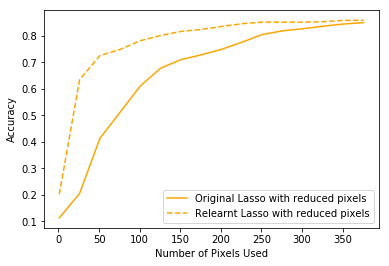

In [41]:
fig, ax = plt.subplots()
ax.plot(X,lassoAcImp,label='Original Lasso with reduced pixels',c=orange,linestyle='-')
ax.plot(X,rLassoAccuracy,label='Relearnt Lasso with reduced pixels',c=orange,linestyle='--')
ax.set_xlabel('Number of Pixels Used')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

In [42]:
rRidgeAccuracy = [LearnReducedModelRidge(i) for i in X]

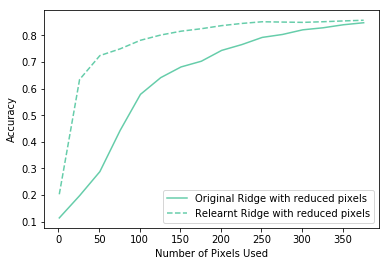

In [43]:
fig, ax = plt.subplots()
ax.plot(X,ridgeAcImp,label='Original Ridge with reduced pixels',c=mediumAquamarine,linestyle='-')
ax.plot(X,rRidgeAccuracy,label='Relearnt Ridge with reduced pixels',c=mediumAquamarine,linestyle='--')
ax.set_xlabel('Number of Pixels Used')
ax.set_ylabel('Accuracy')
ax.legend()
plt.savefig('./Images/ridgeRelearnt.png')
plt.show()

In [44]:
rPinvAccuracy = [LearnReducedModelPInv(i) for i in X]

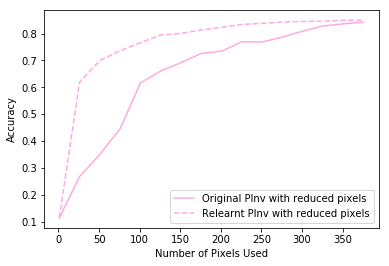

In [45]:
fig, ax = plt.subplots()
ax.plot(X,pinvAcImp,label='Original PInv with reduced pixels',c=millenialPink,linestyle='-')
ax.plot(X,rPinvAccuracy,label='Relearnt PInv with reduced pixels',c=millenialPink,linestyle='--')
ax.set_xlabel('Number of Pixels Used')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

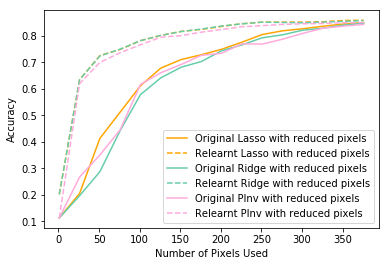

In [46]:
# AND plot them all at once
# WILD
fig, ax = plt.subplots()
ax.plot(X,lassoAcImp,label='Original Lasso with reduced pixels',c=orange,linestyle='-')
ax.plot(X,rLassoAccuracy,label='Relearnt Lasso with reduced pixels',c=orange,linestyle='--')
ax.plot(X,ridgeAcImp,label='Original Ridge with reduced pixels',c=mediumAquamarine,linestyle='-')
ax.plot(X,rRidgeAccuracy,label='Relearnt Ridge with reduced pixels',c=mediumAquamarine,linestyle='--')
ax.plot(X,pinvAcImp,label='Original PInv with reduced pixels',c=millenialPink,linestyle='-')
ax.plot(X,rPinvAccuracy,label='Relearnt PInv with reduced pixels',c=millenialPink,linestyle='--')
ax.set_xlabel('Number of Pixels Used')
ax.set_ylabel('Accuracy')
ax.legend()
plt.savefig('./Images/allRelearnt.png')
plt.show()

## Question 4: Redo the analysis with each digit individually to find the most important pixels for each digit.

In [48]:
# create weights for each digit
#  using train_labels because there didn't seem to be any nice way to do equal vectors arg thing
ws = [np.mean(A[np.argwhere(train_labels==i)[:,0]],axis=0) for i in range(0,10)]

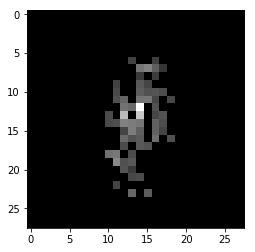

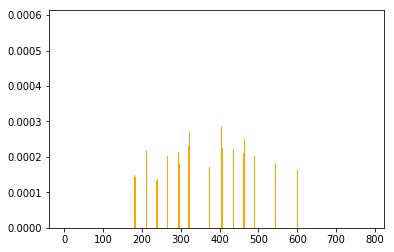

In [49]:
# Plot w, weight for ALL (training) data
pixelQuantity = 64
iP = FindImportantPixels(lassoModel.coef_.T,pixelQuantity,w,norm=2)
plt.imshow(Vector2Image(iP),cmap='gray')
plt.show()
plt.bar(range(len(iP)),iP,color=orange)
plt.show()

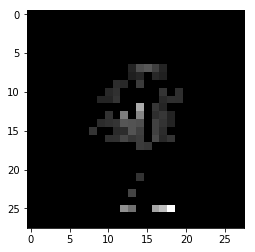

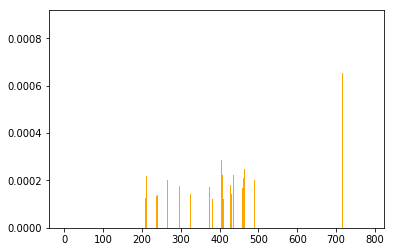

In [50]:
# Plot one of the digits, to check stuff is working
iP = FindImportantPixels(lassoModel.coef_.T,pixelQuantity,ws[9],norm=2)
plt.imshow(Vector2Image(iP),cmap='gray')
plt.show()
plt.bar(range(len(iP)),iP,color=orange)
plt.show()

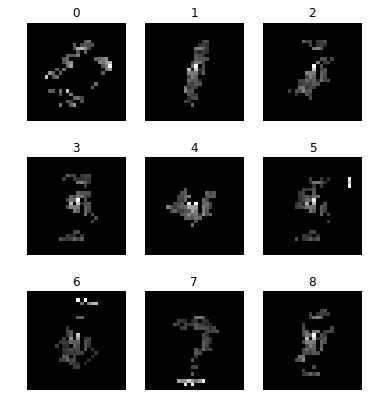

In [51]:
# Pretty plot them all in one go
#  Exlcuding 9, who liked nine anyways
fig, axs = plt.subplots(3, 3,figsize=(6,7))
#plt.subplots_adjust(bottom=-.1,top=1) # This seems suuper dodge
for i in range(9):
    iP = FindImportantPixels(lassoModel.coef_.T,pixelQuantity,ws[i],norm=2)
    axs[i//3,i%3].imshow(Vector2Image(iP),cmap='gray',label=str(i))
    axs[i//3,i%3].set_title(str(i))
    axs[i//3,i%3].axis('off')
    
plt.autoscale()
plt.savefig('./Images/importantPixelsDigits.png')
plt.show()

In [52]:
# Choose to investigate PInv so that in my report my colour scheme is uniformly used
#  This is not a good reason!
pinvAcImp  = CalculateAccuracyWithImportance(X,Atest,Btest,pinvMatrix,w,mat=True)
pinvAcImps = [CalculateAccuracyWithImportance(X,Atest,Btest,pinvMatrix,wi,mat=True) for wi in ws]

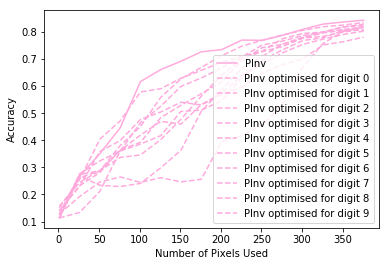

In [53]:
# Horrid graph, but helps see it all in one go
#  Would not publish it anywhere of note (but possibly the daily mail)
fig, ax = plt.subplots()

ax.plot(X,pinvAcImp,label='PInv',c=millenialPink,linestyle='-')
for i in range(len(ws)):
    ax.plot(X,pinvAcImps[i],label='PInv optimised for digit '+str(i),c=millenialPink,linestyle='--')
ax.set_xlabel('Number of Pixels Used')
ax.set_ylabel('Accuracy')

ax.legend()
plt.show()

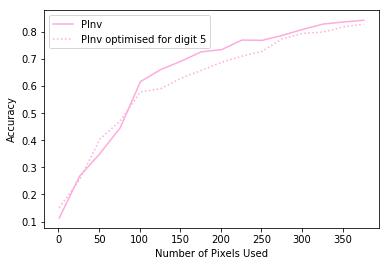

In [54]:
# Just Pick one of the digits to look at with scrutiny
#  Picked five because it turns out to go above the original line, completely uniquely
a = 5
fig, ax = plt.subplots()

ax.plot(X,pinvAcImp,label='PInv',c=millenialPink,linestyle='-')
ax.plot(X,pinvAcImps[a],label='PInv optimised for digit '+str(a),c=millenialPink,linestyle='dotted')
ax.set_xlabel('Number of Pixels Used')
ax.set_ylabel('Accuracy')

ax.legend()
plt.savefig('./Images/pinvDigitOptimised.png')
plt.show()